In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [112]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [113]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,768.700012,768.700012,NaN
1,0.0,765.415008,765.415008,0.0
2,0.0,764.283346,764.283346,0.0
3,0.0,768.842514,768.842514,0.0
4,0.0,773.176013,773.176013,0.0
...,...,...,...,...
247,0.0,976.255005,983.440002,0.0
248,0.0,982.058339,985.941671,0.0
249,0.0,986.876668,988.381668,0.0
250,1.0,994.908335,990.628337,1.0


In [114]:
def buy_stock(
    current_price,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    current_price = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    holdings = 0

    def buy(i, initial_money, holdings):
        shares = initial_money // current_price[i]
        if current_price[i] > initial_money :
            print("Share price greater than investment")
        elif shares < 1:
            print(
                'day %d: total balances %f, not enough free float to buy a unit at price %f'
                % (i, initial_money, current_price[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * current_price[i]
            holdings += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * current_price[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, holdings

    for i in range(current_price.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, holdings = buy(
                i, initial_money, holdings
            )
            states_buy.append(i)
        elif state == -1:
            if holdings == 0:
                    print('day %d: cannot sell anything, holdings 0' % (i))
            else:
                if holdings > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = holdings
                holdings -= sell_units
                total_sell = sell_units * current_price[i]
                initial_money += total_sell
                try:
                    invest = (
                        (current_price[i] - current_price[states_buy[-1]])
                        / current_price[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [115]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 6: buy 1 units at price 762.559998, total balance 9237.440002
day 9, sell 1 units at price 758.489990, investment -0.533730 %, total balance 9995.929992,
day 15: buy 1 units at price 760.989990, total balance 9234.940002
day 20, sell 1 units at price 747.919983, investment -1.717501 %, total balance 9982.859985,
day 26: buy 1 units at price 789.289978, total balance 9193.570007
day 37, sell 1 units at price 791.549988, investment 0.286335 %, total balance 9985.119995,
day 45: buy 1 units at price 806.650024, total balance 9178.469971
day 62, sell 1 units at price 798.530029, investment -1.006632 %, total balance 9977.000000,
day 69: buy 1 units at price 819.239990, total balance 9157.760010
day 84, sell 1 units at price 831.909973, investment 1.546553 %, total balance 9989.669983,
day 85: buy 1 units at price 835.369995, total balance 9154.299988
day 96, sell 1 units at price 817.580017, investment -2.129593 %, total balance 9971.880005,
day 104: buy 1 units at price 834.570007, to

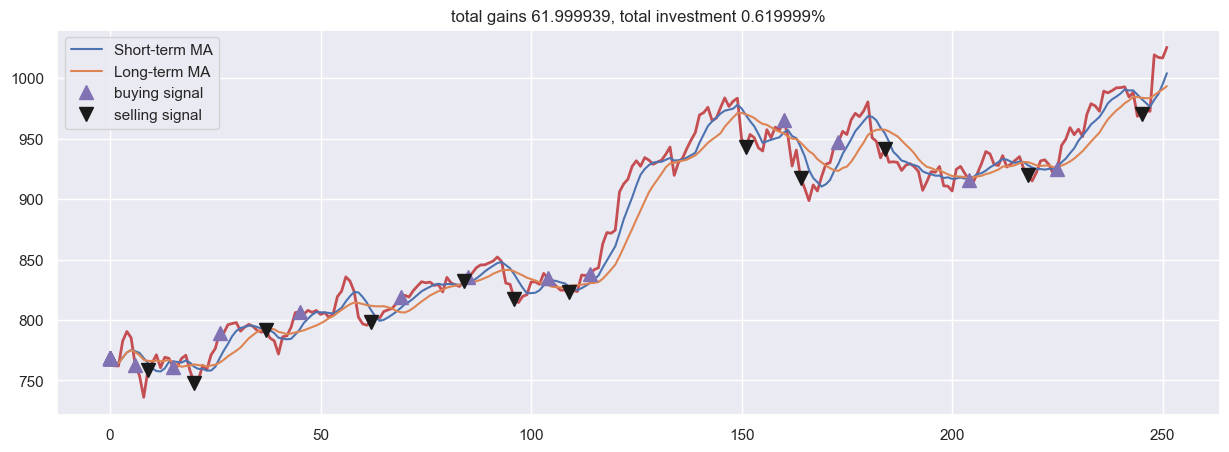

In [116]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
# Plot moving average lines
plt.plot(signals['short_ma'], label='Short-term MA')
plt.plot(signals['long_ma'], label='Long-term MA')
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

The df and signals DataFrames are both O(n) in size. The states_buy and states_sell lists are both O(m) in size, where m is the number of times the code buys or sells stock. Therefore, the total space complexity of the code is O(n + m). 
m and n are the number of times the code buys and sells stock, respectively.